In [13]:
import pints
import pints.toy
import pints.plot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate
import streamlit  


# Understanding Predator-Prey Dynamics Using the Lotka-Volterra Model 

## Introduction

This Python notebook will -hopefully- accompany the article "Ten quick tips for performing inference for differential equation models."

At the beginning of the notebook, we introduce a differential equation model used to describe the dynamics of predator-prey interactions in biological systems. We then attempt to fit this model to two distinct ecological datasets: the [Isle Royale Wolf and Moose](https://isleroyalewolf.org/data/data/home.html) dataset, and the [Hudson Bay Lynx and Hare](https://www.science.unitn.it/AnalisiInfoTLC/SSP/SSP14_15/projects/Elton-1942-J-Anim-Ecol.pdf) dataset. We also discuss the problems that arise as we attempt to solve these example inference problems.

## Model

The [Lotka-Volterra model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations), introduced independently by Alfred J. Lotka and Vito Volterra in 1910 and 1926 respectively, is a mathematical framework consisting of two ODEs used to describe the dynamics of predator-prey interactions in biological systems.

The model has 2 states $x$ and $y$, where $x$ represents a population of prey, and $y$ represents a population of predators as well as four model parameters $a, b, c$, and $d$.
It is described by the ODEs:

$$ \frac{dx}{dt} = ax - bxy $$

and

$$ \frac{dy}{dt} = -cy + dxy $$

There are also initial conditions: $$ x(0) = x_0 , y(0) = y_0 $$ For which the time series and phase plane solutions are, 

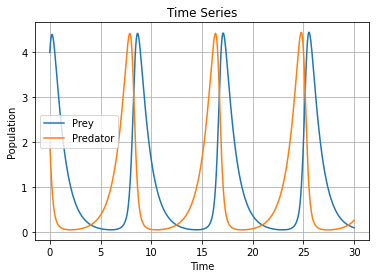

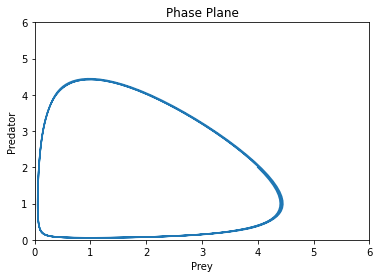

In [14]:
# Example time series and phase plane solutions using arbitrary parameters and simulated data 
a = 1. 
b = 1.
c = 1.
d = 1.
x0 = 4.
y0 = 2

Nt = 1000
tmax = 30.
t = np.linspace(0.,tmax, Nt)

class LotkaVolterraModel(pints.ForwardModel):

    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol

    def n_outputs(self):
        """ See :meth:`pints.ForwardModel.n_outputs()`. """
        return 2

    def n_parameters(self):
        return 4

    def simulate(self, parameters, times):
        a, b, c, d = parameters

        def dy(t, state):
            y, x = state
            
            dy = -c * y + d * x * y
            dx= a * x - b * x * y 
            
            return (dy, dx)

        initial_condition = x0, y0

        res = scipy.integrate.solve_ivp(
            dy,
            (t[0], t[-1]),
            initial_condition,
            t_eval=t)
        
        return res.y.T
    
m = LotkaVolterraModel()
y = m.simulate([a,b,c,d], t)
plt.figure()
plt.grid()
plt.title("Time Series")
plt.plot(t, y[:,0], '-', label = 'Prey')
plt.plot(t, y[:,1], '-', label = "Predator")
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()

plt.show()
plt.figure()
plt.title("Phase Plane")
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.plot(y[:, 0], y[:, 1])
plt.show()

## Analysis of the Isle Royale Wolf and Moose Dataset 
The Isle Royale Wolf and Moose dataset tracks the long-term population dynamics of wolves and moose on an island in the Great Lakes, offering insights into predator-prey interactions in a relatively isolated ecosystem. 

In [15]:
def load_wolf_moose_data(file_location):
    """Load the Wolves & Moose of Isle Royale data from csv file.
    
    Parameters
    ----------
    file_location : str
        path to the csv file containing the wolf-moose population numbers. The file should contain 
        the year in the first column, no. of moose in the second column, and the no. of wolves in the third column.

    Returns
    -------
    pandas.DataFrame
        Wolves & Moose of Isle Royale
    """
    names = ["year", "wolf", "moose"]
    df = pd.read_csv(file_location, header=None, names=names)
    return df

df = load_wolf_moose_data("wolf_moose_data.csv")
df['modified time'] = df['year'].values - 1959
mod_times = df['modified time'].values
observed_data = df[['wolf', 'moose']].values
init_wolves, init_moose = df['wolf'].iloc[0], df['moose'].iloc[0]

class LotkaVolterraModel(pints.ForwardModel):

    def __init__(self, method="RK45", rtol=1e-6, atol=1e-6):
        """
        Parameters
        ----------
        method : str or scipy solver
            Solver method for solving ODE
        rtol : float
            Relative tolerance of ODE solution (applies to adaptive solvers)
        atol : float
            Absolute tolerance of ODE solution (applies to adaptive solvers)
        """
        super().__init__()
        self.method = method
        self.rtol = rtol
        self.atol = atol

    def n_outputs(self):
        """ See :meth:`pints.ForwardModel.n_outputs()`. """
        return 2

    def n_parameters(self):
        return 4

    def simulate(self, parameters, times):
        a, b, c, d = parameters

        def dy(t, state):
            y, x = state
            
            dy = -c * y + d * x * y
            dx= a * x - b * x * y 
            
            return (dy, dx)

        initial_condition = np.asarray([np.log(init_wolves), np.log(init_moose)])

        res = scipy.integrate.solve_ivp(
            dy,
            (mod_times[0], mod_times[-1]),
            initial_condition,
            t_eval=mod_times)
        
        return res.y.T
    
m = LotkaVolterraModel()

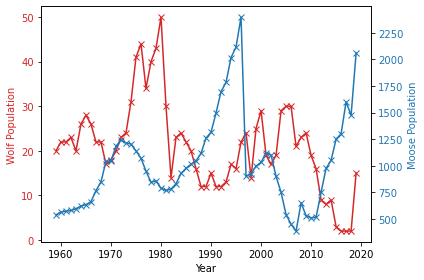

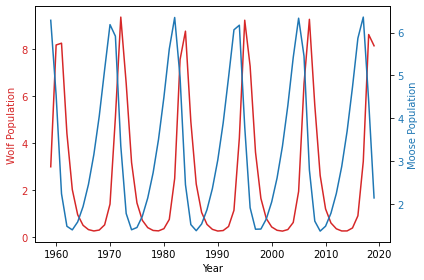

In [16]:
times = mod_times + 1959

# Plot wolf and moose populations
fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(times , df['wolf'], 'x-', color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(times, df['moose'], 'x-', color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

# Make a model object and run a simulation at arbitrary parameter values
# times1 = np.linspace(0, 20, 100)
params = [0.28, 0.11, 1.37, 0.42]
#init_wolves, init_moose = 5, 30
#df['wolf'].iloc[0], df['moose'].iloc[0]
y = m.simulate(params, mod_times)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Year')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(times, y[:, 0], color='tab:red', label='Wolves')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(times, y[:, 1], color='tab:blue', label='Moose')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
plt.show()

In [18]:
# Step 5: Set up the problem
problem = pints.MultiOutputProblem(m , mod_times, np.log(observed_data))
error = pints.SumOfSquaresError(problem)

transformation = pints.RectangularBoundariesTransformation(
    [0.01, 0.01, 0.01, 0.01],
    [10, 10, 10, 10])

opt = pints.OptimisationController(
    error,
    [0.5, 0.02, 0.1, 0.5],
    method=pints.CMAES,
    transformation=transformation
)

opt.set_log_interval(20)
opt.set_max_evaluations(20000)

found_parameters, found_value = opt.run()

print("Fit parameters:", found_parameters)

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 8
Iter. Eval. Best      Current   Time m:s
0     8      93195.38  93195.38   0:00.1
1     16     3056.74   3056.74    0:00.1
2     24     969.0518  969.0518   0:00.2
3     32     969.0518  1432.636   0:00.2
20    168    55.38583  55.38583   0:00.6
40    328    48.7255   48.7255    0:00.7
60    488    46.73433  46.73433   0:00.9
80    648    46.04858  46.04858   0:01.0
100   808    44.16085  44.16085   0:01.2
120   968    41.92945  42.20928   0:01.3
140   1128   39.65079  39.70961   0:01.5
160   1288   38.84737  38.84737   0:01.6
180   1448   38.52569  38.52569   0:01.7
200   1608   38.4127   38.4127    0:01.9
220   1768   38.36859  38.36859   0:02.0
240   1928   38.35374  38.35374   0:02.2
260   2088   38.35191  38.35196   0:02.3
280   2248   38.35183  38.35183   0:02.4
300   2408   38.35183  38.35183   0:02.6
320   2568   38.35183  38.35183   0:02.7
340 

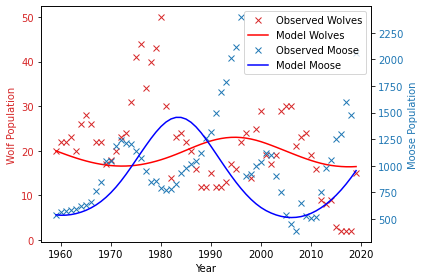

In [19]:
# Evaluate the model with the found parameters and plot the results
fig, ax1 = plt.subplots()

# Plot observed wolf population
ax1.set_xlabel('Year')
ax1.set_ylabel('Wolf Population', color='tab:red')
ax1.plot(times, observed_data[:, 0], 'x', label='Observed Wolves', color='tab:red')
ax1.plot(times, np.exp(problem.evaluate(found_parameters)[:, 0]), label='Model Wolves', color='red')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Plot observed moose population
ax2 = ax1.twinx()
ax2.set_ylabel('Moose Population', color='tab:blue')
ax2.plot(times, observed_data[:, 1], 'x', label='Observed Moose', color='tab:blue')
ax2.plot(times, np.exp(problem.evaluate(found_parameters)[:, 1]), label='Model Moose', color='blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

While performing inference on this dataset, we encountered challenges. The optimization processes frequently failed, producing inconsistent fits with each run, indicating that our model was inappropriate. This inconsistency arose because the wolf and moose populations are influenced by numerous factors beyond predator-prey interactions,  such as [ticks, inbreeding, and climate variations](https://en.wikipedia.org/wiki/Wolves_and_moose_on_Isle_Royale). To address this, we sought a [generalized model](https://chance.dartmouth.edu/chance_news/for_chance_news/ChanceNews13.04/MooseWolfMontroll.pdf) that could better accommodate complexities, but the increased computational demands made the code impractically slow as there were too many parameters to infer with too few data points.  

## Analysis of the Hudson Bay Lynx and Hare Dataset 

Consequently, we reverted to the classic Hudson Bay Company’s Lynx and Hare dataset, a standard example for the Lotka-Volterra model, and successfully performed inference by using a program similar to one illustrated above as well as an interactive data app-making framework known as [Streamlit](https://streamlit.io/) which enabled us to explore 20–30 year windows within the dataset (look at separate streamlitapp.py file for more details on this).

In [5]:
!streamlit run streamlitappcopy.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8506
  Network URL: http://192.168.0.125:8506

/Users/sajai/Documents/lotka-volterra-wolf-moose/streamlitapp.py:27: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
Using Haario-Bardenet adaptive covariance MCMC
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     8      0         0         0.5       0          0:00.0
2     12     0.333     0         0.333     0.333      0:00.0
3     16     0.25      0         0.25      0.25       0:00.1
20    84     0.238     0.19      0.238     0.286      0:00.3
40    164    0.122     0.0976    0.244     0.22       0:00.6
60    244    0.082     0.0656    0.213     0.147541   0:00.9
80    324    0.0741    0.0988    0.185     0.111      0:01.3
100   404    0.0891    0.119     0.1

Historical analyses, including the [influential work](http://pcleon.if.ufrgs.br/pub/listas-sistdin/MurrayI.pdf) by J.D. Murray, have often focused on specific periods within this dataset, leading to conclusions that have influenced ecological understanding for decades. For example, Murray’s analysis suggested that hares prey on lynxes, a counterintuitive claim that has been widely discussed in the literature. To test this, we replicated his analysis and found discrepancies in both the data he used and the phase plane graphs he generated. When we generated the phase plane graph for the 1875-1904 period that Murray analysed, it did not match his results (run the inference for this period using the app and compare with Murray's on pg. 84 of the book). 

Furthermore, our results indicated that the data historically analysed were selectively chosen and may not accurately represent the dynamics of the entire dataset. We conducted optimization fits on different 20-year windows of the data and found that the model was able only to fit 2 windows relatively well; in all other windows, the model did not fit the data. This strongly suggests that the relatively simple deterministic Lotka-Volterra model for this dataset may not be a good approximation to the underlying system across the whole time period as ecological systems are inherently stochastic due to factors such as [climate, disease outbreak, and other random events](https://www.researchgate.net/publication/242783962_Factors_affecting_harelynx_dynamics_in_the_classic_time_series_of_the_Hudson_Bay_Company_Canada).

## Conclusions 
Our analysis revealed significant challenges in using the Lotka-Volterra model to describe the Isle Royale Wolf & Moose dataset due to additional unmodelled factors like ticks and inbreeding. This resulted in inconsistent optimization fits, highlighting the model's inappropriateness for this data. We then analyzed the Hudson Bay Company’s Lynx and Hare dataset and discovered that the model was only able to fit well for a small minority of the overall time series, indicating the model’s inadequacy for describing this system. Our results highlight the importance of thinking carefully about the underlying system being modelled (and likely talking to subject-matter experts) before attempting to fit models to data.